# Predicting Democratic Backsliding

## Import Packages

In [318]:
# Data Wrangling
import pandas as pd
import numpy as np
import country_converter as coco
import missingno as miss

# Plotting libraries
from plotnine import *
import matplotlib.pyplot as plt

# For pre-processing data 
from sklearn import preprocessing as pp 
from sklearn.compose import ColumnTransformer 

# For splits and CV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold # Cross validation 
from sklearn.model_selection import cross_validate # Cross validation 
from sklearn.model_selection import GridSearchCV # Cross validation + param. tuning.

# Machine learning methods 
from sklearn.naive_bayes import GaussianNB as NB
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.tree import DecisionTreeClassifier as DT
from sklearn.ensemble import RandomForestClassifier as RF
from sklearn import tree # For plotting the decision tree rules

# For evaluating our model's performance
import sklearn.metrics as m

# Pipeline to combine modeling elements
from sklearn.pipeline import Pipeline

# Model Interpretation
from sklearn.inspection import partial_dependence
from sklearn.inspection import plot_partial_dependence
from sklearn.inspection import permutation_importance
from pdpbox import pdp

## Load the democracy data and select features

In [319]:
vdem = pd.read_csv("Data/Country_Year_V-Dem_Full+others_CSV_v10/V-Dem-CY-Full+Others-v10.csv")

In [320]:
vdem = vdem.loc[vdem['year'] >= 1960]

In [321]:
civil_liberties = vdem[["country_name", "year", "v2x_frassoc_thick", "v2x_suffr", "v2xel_frefair", "v2cltort", "v2clkill", "v2cltrnslw", "v2clrspct", "v2clacjust", "v2clsocgrp", "v2clacfree", "v2clrelig", "v2caassemb", "v2xcl_acjst", "v2x_clpol", "v2x_freexp"]]

In [322]:
civil_society = vdem[["country_name", "year", "v2x_cspart", "v2cseeorgs", "v2csreprss", "v2cscnsult", "v2csstruc_0", "v2csstruc_1", "v2csstruc_2", "v2csprtcpt", "v2csantimv", "v2csrlgrep"]]

In [323]:
media = vdem[["country_name", "year", "v2mecenefm", "v2mecenefi", "v2mecenefibin", "v2mecrit", "v2merange", "v2meharjrn", "v2mebias"]]

In [324]:
access_services = vdem[["country_name", "year", "v2pepwrses", "v2pepwrsoc", "v2peedueq", "v2pehealth", "v2peapsecon", "v2peasjsoecon", "v2peasbecon", "v2clgencl", "v2peapsgen", "v2pepwrgeo", "v2clgeocl", "v2peapsgeo", "v2peasjgeo", "v2peasbegeo", "v2clpolcl", "v2peapspol", "v2peasjpol", "v2peasbepol"]]

In [325]:
strife = vdem[["country_name", "year", "v2cacamps", "v2caviol", "v2cagenmob", "v2cademmob", "v2caautmob", "v2castate", "v2catrauni", "v2capolit", "v2canonpol"]]

In [326]:
polity_data = pd.read_csv("Data/p5v2018.csv")

In [327]:
polity_data = polity_data[["country", "year", "polity2", "durable"]]

In [328]:
polity_data = polity_data.loc[polity_data['year'] >= 1960]

In [329]:
polity_data

,country,year,polity2,durable
160,Afghanistan,1960,-10.0,NaN
161,Afghanistan,1961,-10.0,NaN
162,Afghanistan,1962,-10.0,NaN
163,Afghanistan,1963,-10.0,NaN
164,Afghanistan,1964,-7.0,0.0
...,...,...,...,...
17543,Zimbabwe,2014,4.0,1.0
17544,Zimbabwe,2015,4.0,2.0
17545,Zimbabwe,2016,4.0,3.0
17546,Zimbabwe,2017,4.0,4.0


## Load the econ data 

In [330]:
# read in GDP per capita growth data
GDPPC_growth = pd.read_csv("Data/gdp_per_capita_yearly_growth- Gapminder.csv")

In [331]:
# melt so that we have country year as units of observation
GDPPC_growth = GDPPC_growth.melt(id_vars= 'country', var_name = 'year', value_name='GDPpc_growth')

In [332]:
# change year to numeric
GDPPC_growth['year'] = pd.to_numeric(GDPPC_growth['year'])

In [333]:
# keep only observations from 1960 onwards
GDPPC_growth = GDPPC_growth.loc[GDPPC_growth['year'] >= 1960]

In [334]:
# read in real GDP growth data
GDP_growth = pd.read_csv("Data/gdp_total_yearly_growth- Gapminder.csv")

In [335]:
# melt so that we have country year as units of observation
GDP_growth = GDP_growth.melt(id_vars= 'country', var_name = 'year', value_name='GDP_growth')

In [336]:
# change year to numeric
GDP_growth['year'] = pd.to_numeric(GDP_growth['year'])

In [337]:
# keep only observations from 1960 onwards
GDP_growth = GDP_growth.loc[GDP_growth['year'] >= 1960]

In [338]:
Poverty = pd.read_csv("Data/Poverty Headcount Ratio WB.csv", skiprows=4)

In [339]:
Poverty.drop(columns = ["Indicator Name", "Indicator Code", "Country Code", "Unnamed: 65"], inplace=True)

In [340]:
Poverty = Poverty.melt(id_vars= 'Country Name', var_name = 'year', value_name='Poverty Rate')

In [341]:
Poverty['year'] = pd.to_numeric(Poverty['year'])

In [342]:
Unemployment = pd.read_csv("Data/Unemployment-gapminderILO.csv")

In [343]:
Unemployment = Unemployment.melt(id_vars= 'country', var_name = 'year', value_name='Unemployment')

In [344]:
Unemployment['year'] = pd.to_numeric(Unemployment['year'])

In [345]:
# keep only observations from 1960 onwards
Unemployment = Unemployment.loc[Unemployment['year'] >= 1960]

In [346]:
Gini = pd.read_csv("Data/World Bank Gini.csv", skiprows=4)

In [347]:
Gini.drop(columns = ["Indicator Name", "Indicator Code", "Country Code", "Unnamed: 65"], inplace=True)

In [348]:
Gini = Gini.melt(id_vars= 'Country Name', var_name = 'year', value_name='Gini')

In [349]:
Gini['year'] = pd.to_numeric(Gini['year'])

## Make sure countries line up

In [350]:
len(vdem.country_name.unique())
# vdems has less countries than gapminder and GDP

182

In [351]:
len(polity_data.country.unique())

180

In [352]:
len(GDP_growth.country.unique())

194

In [353]:
len(GDPPC_growth.country.unique())

194

In [354]:
len(Poverty["Country Name"].unique())

264

In [355]:
len(Unemployment.country.unique())

186

In [356]:
len(Gini["Country Name"].unique())

264

In [357]:
GDP_names = GDP_growth.country.to_list()
GDP_names = coco.convert(GDP_names, to = 'name_short', not_found = None)

In [358]:
GDPPC_names = GDPPC_growth.country.to_list()
GDPPC_names = coco.convert(GDPPC_names, to = 'name_short', not_found = None)

In [359]:
Poverty_names = Poverty["Country Name"].to_list()
Poverty_names = coco.convert(Poverty_names, to = 'name_short', not_found = None)

t found in regex
East Asia & Pacific ( not found in regex
Early-demographic dividend not found in regex
East Asia & Pacific not found in regex
Europe & Central Asia ( not found in regex
Europe & Central Asia not found in regex
Euro area not found in regex
European Union not found in regex
Fragile and conflict affected situations not found in regex
High income not found in regex
Heavily indebted poor countries (HIPC) not found in regex
IBRD only not found in regex
IDA & IBRD total not found in regex
IDA total not found in regex
IDA blend not found in regex
IDA only not found in regex
Not classified not found in regex
Latin America & Caribbean ( not found in regex
Latin America & Caribbean not found in regex
Least developed countries: UN classification not found in regex
Low income not found in regex
Lower middle income not found in regex
Low & middle income not found in regex
Late-demographic dividend not found in regex
Middle East & North Africa not found in regex
Middle income not fou

In [360]:
Unemployment_names = Unemployment.country.to_list()
Unemployment_names = coco.convert(Unemployment_names, to = 'name_short', not_found = None)

In [361]:
Gini_names = Gini["Country Name"].to_list()
Gini_names = coco.convert(Gini_names, to = 'name_short', not_found = None)

t found in regex
East Asia & Pacific ( not found in regex
Early-demographic dividend not found in regex
East Asia & Pacific not found in regex
Europe & Central Asia ( not found in regex
Europe & Central Asia not found in regex
Euro area not found in regex
European Union not found in regex
Fragile and conflict affected situations not found in regex
High income not found in regex
Heavily indebted poor countries (HIPC) not found in regex
IBRD only not found in regex
IDA & IBRD total not found in regex
IDA total not found in regex
IDA blend not found in regex
IDA only not found in regex
Not classified not found in regex
Latin America & Caribbean ( not found in regex
Latin America & Caribbean not found in regex
Least developed countries: UN classification not found in regex
Low income not found in regex
Lower middle income not found in regex
Low & middle income not found in regex
Late-demographic dividend not found in regex
Middle East & North Africa not found in regex
Middle income not fou

In [362]:
# standardize country names
GDPPC_growth.country = GDPPC_names
GDP_growth.country = GDP_names
Poverty["Country Name"] = Poverty_names
Unemployment.country = Unemployment_names
Gini["Country Name"] = Gini_names

In [363]:
# standardize country names with country-converter than keep the countries that overlap
vdem_names = civil_liberties.country_name.to_list()
vdem_names = coco.convert(vdem_names, to = 'name_short', not_found = None)

Republic of Vietnam not found in regex
Republic of Vietnam not found in regex
Republic of Vietnam not found in regex
Republic of Vietnam not found in regex
Republic of Vietnam not found in regex
Republic of Vietnam not found in regex
Republic of Vietnam not found in regex
Republic of Vietnam not found in regex
Republic of Vietnam not found in regex
Republic of Vietnam not found in regex
Republic of Vietnam not found in regex
Republic of Vietnam not found in regex
Republic of Vietnam not found in regex
Republic of Vietnam not found in regex
Republic of Vietnam not found in regex
Republic of Vietnam not found in regex
German Democratic Republic not found in regex
German Democratic Republic not found in regex
German Democratic Republic not found in regex
German Democratic Republic not found in regex
German Democratic Republic not found in regex
German Democratic Republic not found in regex
German Democratic Republic not found in regex
German Democratic Republic not found in regex
German D

In [364]:
polity_names = polity_data.country.tolist()
polity_names = coco.convert(polity_names, to = 'name_short')

Vietnam North not found in regex
Vietnam North not found in regex
Vietnam North not found in regex
Vietnam North not found in regex
Vietnam North not found in regex
Vietnam North not found in regex
Vietnam North not found in regex
Vietnam North not found in regex
Vietnam North not found in regex
Vietnam North not found in regex
Vietnam North not found in regex
Vietnam North not found in regex
Vietnam North not found in regex
Vietnam North not found in regex
Vietnam North not found in regex
Vietnam North not found in regex
Vietnam North not found in regex
Germany East not found in regex
Germany East not found in regex
Germany East not found in regex
Germany East not found in regex
Germany East not found in regex
Germany East not found in regex
Germany East not found in regex
Germany East not found in regex
Germany East not found in regex
Germany East not found in regex
Germany East not found in regex
Germany East not found in regex
Germany East not found in regex
Germany East not found 

In [365]:
polity_data["country"] = polity_names
access_services["country_name"] = vdem_names
civil_liberties["country_name"] = vdem_names
civil_society["country_name"] = vdem_names
media["country_name"] = vdem_names
strife["country_name"] = vdem_names

In [366]:
polity_names = pd.Series(polity_names)
vdem_names = pd.Series(vdem_names)

In [367]:
intersection = pd.Series(np.intersect1d(polity_names, vdem_names))

In [368]:
polity_data = polity_data[polity_data["country"].isin(intersection)]
access_services = access_services[access_services["country_name"].isin(intersection)]
civil_liberties = civil_liberties[civil_liberties["country_name"].isin(intersection)]
civil_society = civil_society[civil_society["country_name"].isin(intersection)]
media = media[media["country_name"].isin(intersection)]
strife = strife[strife["country_name"].isin(intersection)]

## Wrangle institution data

In [369]:
# Set country and year as index for X variables
# should I combine the two or should I set a multi index
access_services.set_index(["country_name", "year"], inplace=True)
civil_liberties.set_index(["country_name", "year"], inplace=True)
civil_society.set_index(["country_name", "year"], inplace=True)
media.set_index(["country_name", "year"], inplace=True)
strife.set_index(["country_name", "year"], inplace=True)

In [370]:
# lag variables- previous year
strife = strife.groupby("country_name").shift()
media = media.groupby("country_name").shift()

In [371]:
# for the y let's drop durable for now
polity_data.drop(columns = "durable", inplace=True)

In [372]:
# Create variable to show change in polity score
shifted_polity = polity_data.groupby("country").apply(lambda x: x - x.shift(1))

In [373]:
polity_data["change in polity"] = shifted_polity.polity2

In [374]:
# create binary variable for presence of backsliding
polity_data["backsliding"] = np.where(polity_data["change in polity"] >= 0, 0, 1) 

In [375]:
# set country year index for Y
polity_data.set_index(["country", "year"], inplace=True)

In [376]:
polity_data

polity2  change in polity  backsliding
country     year                                        
Afghanistan 1960    -10.0               NaN            1
            1961    -10.0               0.0            0
            1962    -10.0               0.0            0
            1963    -10.0               0.0            0
            1964     -7.0               3.0            0
...                   ...               ...          ...
Zimbabwe    2014      4.0               0.0            0
            2015      4.0               0.0            0
            2016      4.0               0.0            0
            2017      4.0               0.0            0
            2018      4.0               0.0            0

[8575 rows x 3 columns]

In [377]:
polity_data.drop(columns = ["polity2", "change in polity"], inplace=True)

In [378]:
# Merge Data
access_services = polity_data.merge(access_services, how = "inner", left_index = True, right_on = ['country_name', 'year'])
civil_liberties = polity_data.merge(civil_liberties, how = "inner", left_index = True, right_on = ['country_name', 'year'])
civil_society = polity_data.merge(civil_society, how = "inner", left_index = True, right_on = ['country_name', 'year'])
media = polity_data.merge(media, how = "inner", left_index = True, right_on = ['country_name', 'year'])
strife = polity_data.merge(strife, how = "inner", left_index = True, right_on = ['country_name', 'year'])

## Wrangle Economic Data

In [379]:
GDPPC_growth.set_index(["country", "year"], inplace= True)
GDP_growth.set_index(["country", "year"], inplace= True)
Poverty.set_index(["Country Name", "year"], inplace= True)
Unemployment.set_index(["country", "year"], inplace= True)
Gini.set_index(["Country Name", "year"], inplace= True)

In [380]:
# Merge all the econ data
Econ_merge = GDPPC_growth.merge(GDP_growth, how="inner", left_index=True, right_index=True).merge(Poverty, how = "inner", left_index=True, right_on=["Country Name", "year"]).merge(Unemployment, how = "inner", left_index=True, right_on= ["country", "year"]).merge(Gini, how="inner", left_index = True, right_on = ["Country Name", "year"])

In [ ]:
 # Lag Data

In [381]:
# Merge with Polity
econ = Econ_merge.merge(polity_data, how = "inner", left_index = True, right_on = ["country", "year"])

## Split the data for strife

In [382]:
# split strife
y = strife.backsliding
X = strife.drop(columns="backsliding")
train_X, test_X, train_y, test_y = train_test_split(X,y,test_size = .25,random_state=202011)

## Explore the training data

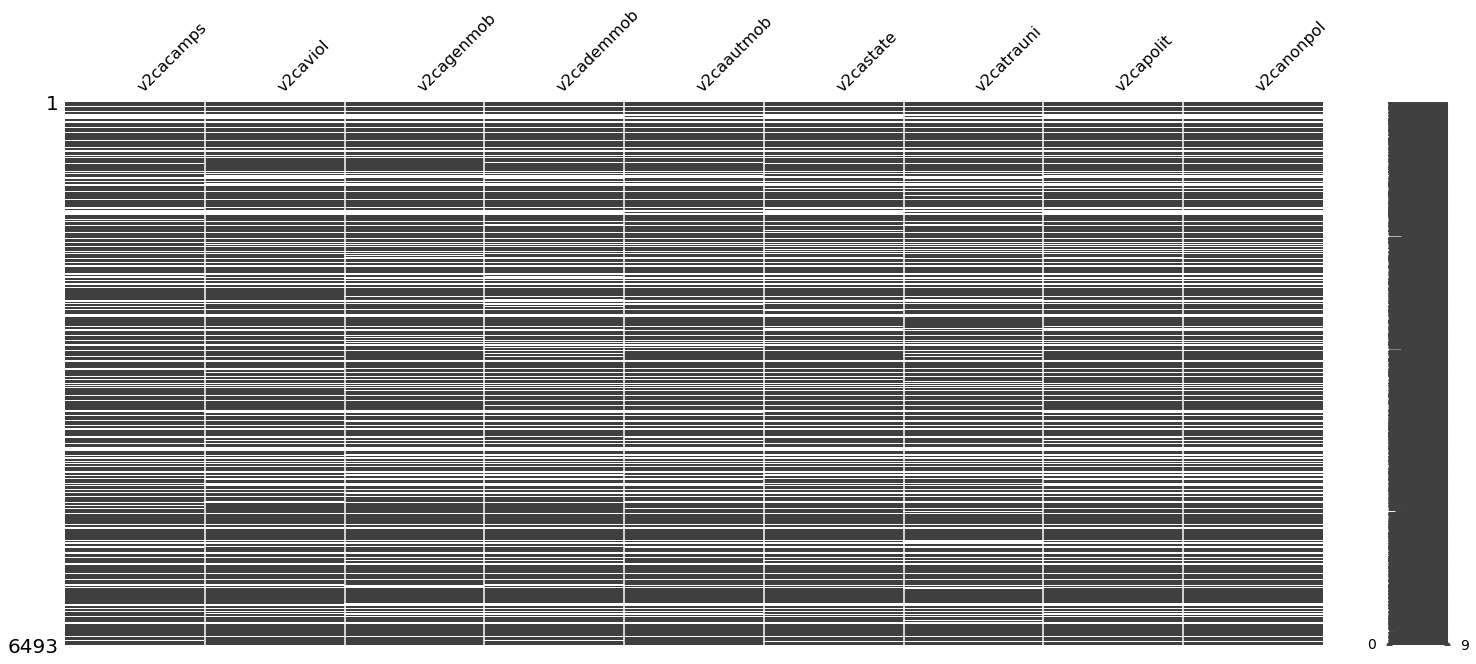

In [383]:
miss.matrix(train_X)

In [384]:
train_X

,,v2cacamps,v2caviol,v2cagenmob,v2cademmob,v2caautmob,v2castate,v2catrauni,v2capolit,v2canonpol
country_name,year,,,,,,,,,
Mexico,1973,-0.788,1.049,0.543,1.710,1.994,1.028,0.138,-0.730,-0.470
Oman,1986,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Guinea,1970,2.287,0.687,-0.406,-1.418,1.584,2.498,-1.059,-0.791,0.887
Turkmenistan,1999,-1.938,-2.410,-1.500,-2.400,1.767,0.834,-2.103,-1.479,-1.674
Papua New Guinea,1996,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
Finland,2000,-1.632,-1.284,-1.276,NaN,-1.840,-2.516,NaN,1.620,2.876
Tanzania,2018,-0.620,-1.041,-0.454,0.004,0.538,1.172,0.216,1.425,0.677
Bolivia,2000,-1.346,-0.724,0.611,-0.531,0.332,-1.795,1.789,0.200,1.115


In [385]:
train_X.dropna(inplace=True)

In [386]:
train_X.describe()

,v2cacamps,v2caviol,v2cagenmob,v2cademmob,v2caautmob,v2castate,v2catrauni,v2capolit,v2canonpol
count,4242.000000,4242.000000,4242.000000,4242.000000,4242.000000,4242.000000,4242.000000,4242.000000,4242.000000
mean,-0.281381,-0.297330,-0.206315,-0.375581,-0.378801,-0.097031,0.451091,0.364141,0.497884
std,1.338783,1.386784,1.269520,1.309998,1.289777,1.467630,1.402762,1.291421,1.148749
min,-3.527000,-3.065000,-3.200000,-2.584000,-2.172000,-2.979000,-2.802000,-2.791000,-2.894000
25%,-1.386000,-1.392250,-1.159750,-1.438000,-1.441000,-1.271000,-0.463000,-0.493000,-0.227000
50%,-0.248000,-0.403000,-0.263000,-0.555000,-0.668000,-0.242000,0.694000,0.476000,0.611000
75%,0.669000,0.661000,0.731250,0.612000,0.512000,1.122000,1.369000,1.263000,1.317000
max,3.816000,3.698000,3.547000,3.691000,3.809000,3.435000,3.722000,3.448000,3.645000


In [387]:
a = train_X.melt()

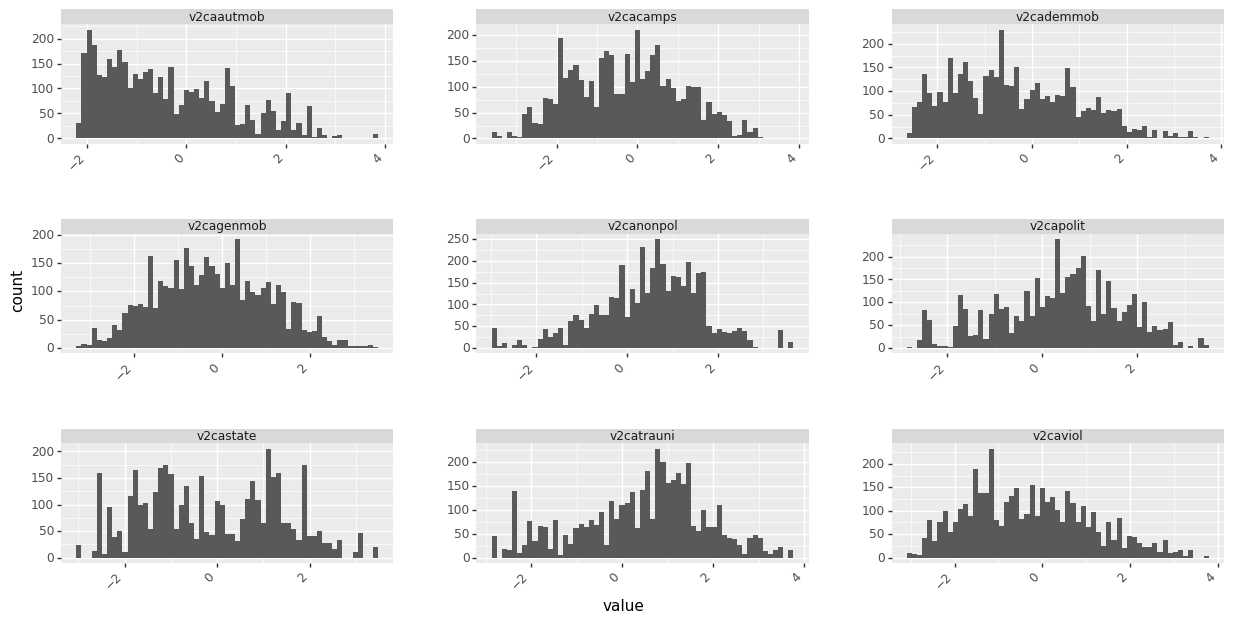

<ggplot: (340957142)>

In [388]:
(
    ggplot(a,aes(x="value")) +
    geom_histogram() +
    facet_wrap("variable" , scales='free') +
    theme(figure_size=(15,7),
          subplots_adjust={'wspace':0.25,
                           'hspace':0.75},
         axis_text_x=element_text(rotation=45, hjust=1))
)

## Make edits to full data

In [389]:
strife.dropna(inplace = True)

# Model

In [390]:
# split strife again
y = strife["backsliding"]
X = strife.drop(columns="backsliding")
train_X, test_X, train_y, test_y = train_test_split(X,y,test_size = .25,random_state=202011)

In [391]:
# Set the folds index to ensure comparable samples
fold_generator = KFold(n_splits=5, shuffle=True,random_state=1234)

# Set preprocess equal to Min Max Scaler to keep our variable distributions
preprocess = pp.MinMaxScaler()

In [392]:
# Build the modeling pipeline
pipe = Pipeline(steps=[('pre_process', preprocess),('model',None)])

search_space = [
    
    # NaiveBayes
    {'model': [NB()]},
    
    # KNN with K tuning param
    {'model' : [KNN()],
     'model__n_neighbors':[5,10,25,50]},
    
    # Decision Tree with the Max Depth Param
    {'model': [DT()],
     'model__max_depth':[2,3,4]},
    
    # Random forest with the N Estimators, max depth, and max features tuning param
    {'model' : [RF()],
    'model__max_depth':[6,7,8],
    'model__n_estimators':[500,1000,1500],
    'model__max_features': [5,10,15]},
    
]

# Grid Search to find the best parameters. The metric used for evaluation is ROC AUC
search = GridSearchCV(pipe, search_space, 
                      cv = fold_generator,
                      scoring='roc_auc',
                      n_jobs=4)

# fit the data with the model
search.fit(train_X,train_y)

GridSearchCV(cv=KFold(n_splits=5, random_state=1234, shuffle=True),
             estimator=Pipeline(steps=[('pre_process', MinMaxScaler()),
                                       ('model', None)]),
             n_jobs=4,
             param_grid=[{'model': [GaussianNB()]},
                         {'model': [KNeighborsClassifier()],
                          'model__n_neighbors': [5, 10, 25, 50]},
                         {'model': [DecisionTreeClassifier()],
                          'model__max_depth': [2, 3, 4]},
                         {'model': [RandomForestClassifier(max_depth=8,
                                                           max_features=5,
                                                           n_estimators=1000)],
                          'model__max_depth': [6, 7, 8],
                          'model__max_features': [5, 10, 15],
                          'model__n_estimators': [500, 1000, 1500]}],
             scoring='roc_auc')

In [393]:
#this is our out of sample AUC score
search.best_score_ 

0.7598449983814491

In [394]:
# what model performs the best
search.best_params_

{'model': RandomForestClassifier(max_depth=8, max_features=5, n_estimators=1000),
 'model__max_depth': 8,
 'model__max_features': 5,
 'model__n_estimators': 1000}

In [395]:
# now what happens if we try on the test data
best_mod = search.best_estimator_

In [396]:
pred_y = best_mod.predict(test_X)
m.roc_auc_score(test_y, pred_y)

0.5336102874557286

In [397]:
m.mean_squared_error(test_y, pred_y)

0.04926108374384237

In [398]:
m.accuracy_score(test_y, pred_y)

0.9507389162561576

In [399]:
score_list = []

In [400]:
score = m.balanced_accuracy_score(test_y, pred_y)
print(score)
score_list.append(score)

0.5336102874557286


In [401]:
confusion_list = []

In [402]:
confusion = m.confusion_matrix(test_y, pred_y)
print(confusion)
confusion_list.append(confusion)

[[1346    3]
 [  67    5]]


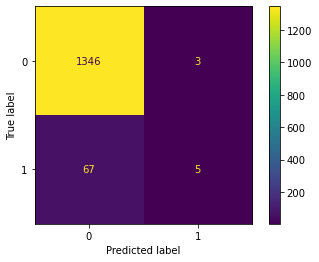

In [403]:
m.plot_confusion_matrix(best_mod, test_X, test_y)

## Variable Importance

In [404]:
# Use variable permutation to derive the importance of each variable
#vi = permutation_importance(best_mod,train_X,train_y,n_repeats=5)

In [405]:
# Organize as a data frame 
#vi_dat = pd.DataFrame(dict(variable=train_X.columns,
                           #vi = vi['importances_mean'],
                           #std = vi['importances_std']))

# Generate intervals
#vi_dat['low'] = vi_dat['vi'] - 2*vi_dat['std']
#vi_dat['high'] = vi_dat['vi'] + 2*vi_dat['std']

# But in order from most to least important
#vi_dat = vi_dat.sort_values(by="vi",ascending=False).reset_index(drop=True)

# view the dataframe
#vi_dat

In [406]:
# Plot variable importance
#(
    #ggplot(vi_dat,
         # aes(x="variable",y="vi")) +
  #  geom_col(alpha=.5) +
  #  geom_point() +
  #  geom_errorbar(aes(ymin="low",ymax="high"),width=.2) +
   # theme_bw() +
   # scale_x_discrete(limits=vi_dat.variable.tolist()) +
   # coord_flip() +
   # labs(y="Reduction in AUC ROC",x="",title="Variable Importance")
#)

## Split the data for Access to Services

In [407]:
# split 
y = access_services.backsliding
X = access_services.drop(columns="backsliding")
train_X, test_X, train_y, test_y = train_test_split(X,y,test_size = .25,random_state=202011)

## Explore training data

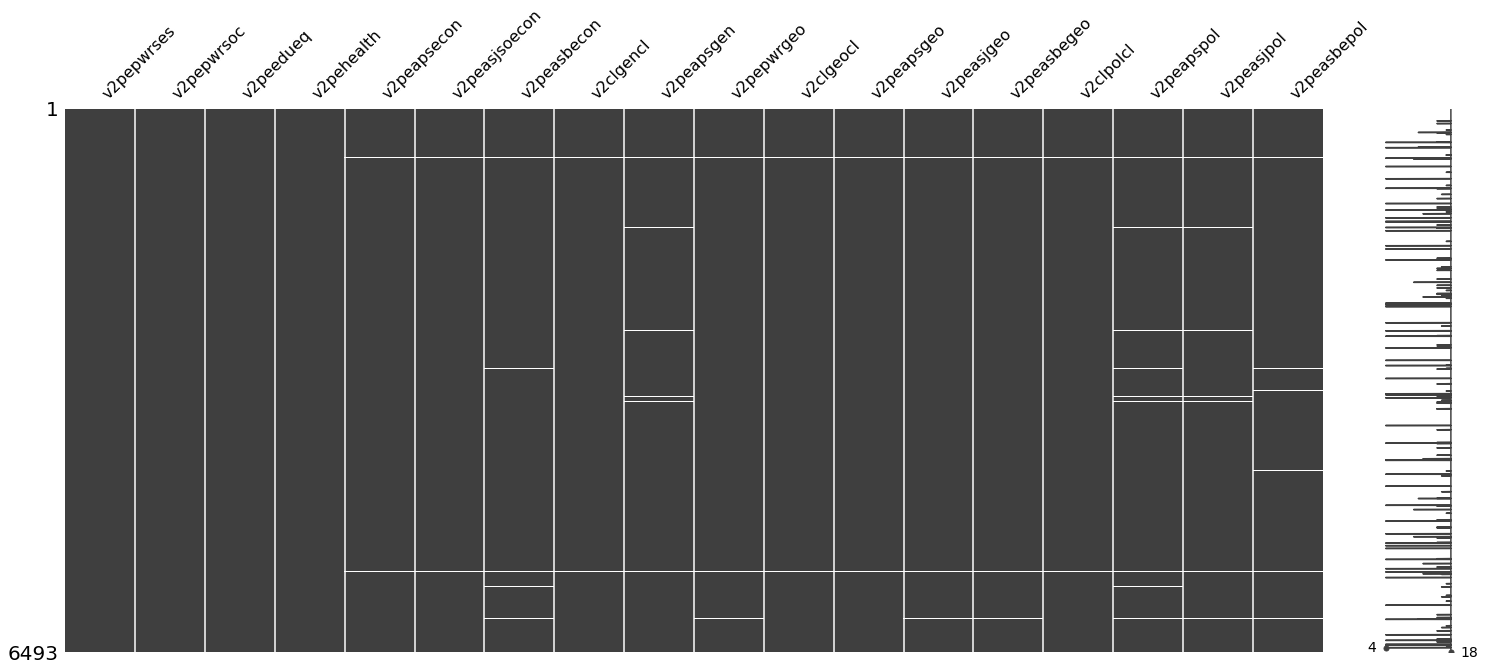

In [408]:
# missingness
miss.matrix(train_X)

In [409]:
train_X.isna().sum()

v2pepwrses         0
v2pepwrsoc         0
v2peedueq          0
v2pehealth         0
v2peapsecon       52
v2peasjsoecon     52
v2peasbecon       82
v2clgencl         52
v2peapsgen       100
v2pepwrgeo        69
v2clgeocl         52
v2peapsgeo        56
v2peasjgeo        65
v2peasbegeo       65
v2clpolcl         52
v2peapspol       125
v2peasjpol       113
v2peasbepol       87
dtype: int64

In [410]:
train_X.dropna(inplace=True)

In [411]:
train_X.describe()

,v2pepwrses,v2pepwrsoc,v2peedueq,v2pehealth,v2peapsecon,v2peasjsoecon,v2peasbecon,v2clgencl,v2peapsgen,v2pepwrgeo,v2clgeocl,v2peapsgeo,v2peasjgeo,v2peasbegeo,v2clpolcl,v2peapspol,v2peasjpol,v2peasbepol
count,6341.000000,6341.000000,6341.000000,6341.000000,6341.000000,6341.000000,6341.000000,6341.000000,6341.000000,6341.000000,6341.000000,6341.000000,6341.000000,6341.000000,6341.000000,6341.000000,6341.000000,6341.000000
mean,0.417881,0.483431,0.242210,0.279112,0.134959,0.384437,0.215630,0.645367,0.199929,0.027224,0.164589,0.251806,0.134620,0.178794,0.414629,0.436222,0.319663,0.217883
std,1.160573,1.265418,1.469457,1.511527,1.375305,1.250836,1.308054,1.256867,1.323747,1.123371,1.188937,1.335438,1.151634,1.289610,1.508998,1.360091,1.432430,1.424664
min,-2.922000,-2.688000,-3.209000,-3.278000,-2.824000,-2.800000,-2.871000,-3.474000,-2.617000,-2.826000,-3.115000,-2.535000,-3.140000,-2.800000,-2.785000,-3.209000,-2.815000,-2.870000
25%,-0.504000,-0.407000,-0.950000,-0.953000,-0.903000,-0.672000,-0.801000,-0.189000,-0.902000,-0.827000,-0.794000,-0.851000,-0.828000,-0.801000,-0.915000,-0.718000,-0.745000,-0.836000
50%,0.600000,0.579000,0.178000,0.148000,-0.158000,0.503000,-0.025000,0.747000,-0.123000,-0.001000,0.212000,0.123000,0.114000,0.006000,0.445000,0.428000,0.160000,-0.052000
75%,1.220000,1.458000,1.385000,1.488000,1.147000,1.240000,1.209000,1.535000,1.316000,0.902000,1.202000,1.350000,1.153000,1.292000,1.612000,1.527000,1.406000,1.368000
max,2.916000,3.206000,3.584000,3.482000,3.535000,3.208000,3.621000,3.264000,2.901000,2.854000,2.834000,2.931000,2.496000,2.754000,3.238000,2.947000,3.417000,3.580000


In [412]:
a = train_X.melt()

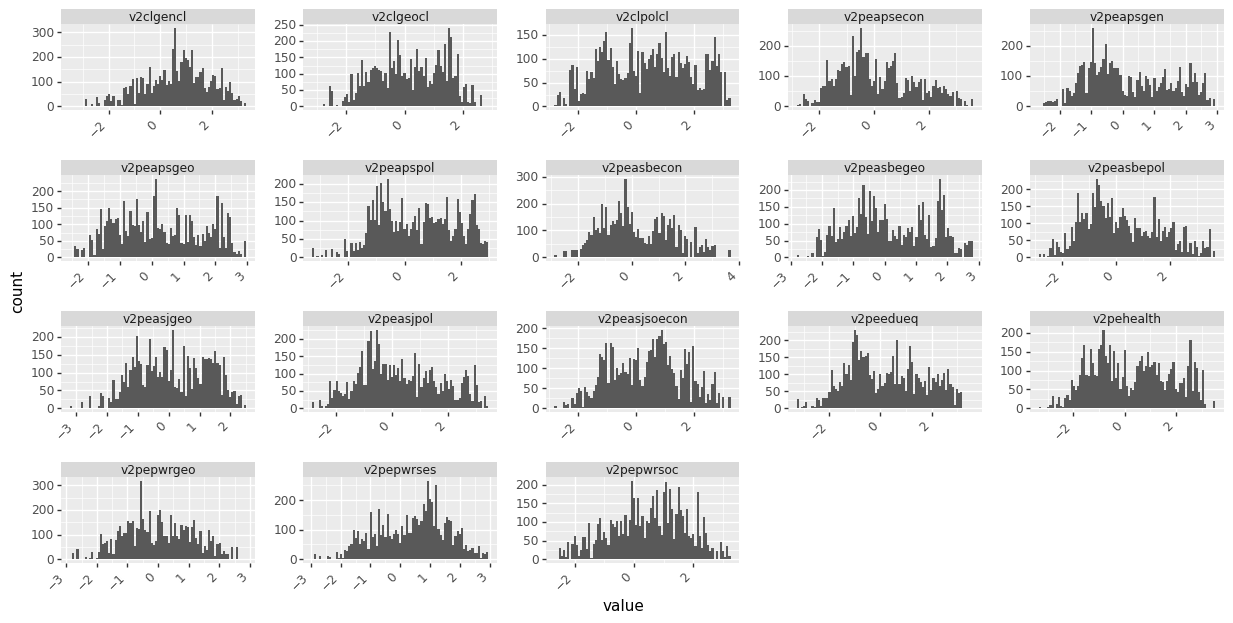

<ggplot: (346353095)>

In [413]:
(
    ggplot(a,aes(x="value")) +
    geom_histogram() +
    facet_wrap("variable" , scales='free') +
    theme(figure_size=(15,7),
          subplots_adjust={'wspace':0.25,
                           'hspace':0.75},
         axis_text_x=element_text(rotation=45, hjust=1))
)

## Make edits to full data

In [414]:
access_services.dropna(inplace = True)

## Split again

In [415]:
# split 
y = access_services.backsliding
X = access_services.drop(columns="backsliding")
train_X, test_X, train_y, test_y = train_test_split(X,y,test_size = .25,random_state=202011)

## Model

In [416]:
# Build the modeling pipeline
pipe = Pipeline(steps=[('pre_process', preprocess),('model',None)])

search_space = [
    
    # NaiveBayes
    {'model': [NB()]},
    
    # KNN with K tuning param
    {'model' : [KNN()],
     'model__n_neighbors':[5,10,25,50]},
    
    # Decision Tree with the Max Depth Param
    {'model': [DT()],
     'model__max_depth':[2,3,4]},
    
    # Random forest with the N Estimators, max depth, and max features tuning param
    {'model' : [RF()],
    'model__max_depth':[6,7,8],
    'model__n_estimators':[500,1000,1500],
    'model__max_features': [5,10,15]},
    
]

# Grid Search to find the best parameters. The metric used for evaluation is ROC AUC
search = GridSearchCV(pipe, search_space, 
                      cv = fold_generator,
                      scoring='roc_auc',
                      n_jobs=4)

# fit the data with the model
search.fit(train_X,train_y)

GridSearchCV(cv=KFold(n_splits=5, random_state=1234, shuffle=True),
             estimator=Pipeline(steps=[('pre_process', MinMaxScaler()),
                                       ('model', None)]),
             n_jobs=4,
             param_grid=[{'model': [GaussianNB()]},
                         {'model': [KNeighborsClassifier()],
                          'model__n_neighbors': [5, 10, 25, 50]},
                         {'model': [DecisionTreeClassifier()],
                          'model__max_depth': [2, 3, 4]},
                         {'model': [RandomForestClassifier(max_depth=8,
                                                           max_features=10,
                                                           n_estimators=1500)],
                          'model__max_depth': [6, 7, 8],
                          'model__max_features': [5, 10, 15],
                          'model__n_estimators': [500, 1000, 1500]}],
             scoring='roc_auc')

In [417]:
#this is our out of sample AUC score
search.best_score_ 

0.7195263349927636

In [418]:
# what model performs the best
search.best_params_

{'model': RandomForestClassifier(max_depth=8, max_features=10, n_estimators=1500),
 'model__max_depth': 8,
 'model__max_features': 10,
 'model__n_estimators': 1500}

In [419]:
# now what happens if we try on the test data
best_mod = search.best_estimator_

In [420]:
pred_y = best_mod.predict(test_X)
m.roc_auc_score(test_y, pred_y)

0.5548947883896242

In [421]:
confusion = m.confusion_matrix(test_y, pred_y)
print(confusion)
confusion_list.append(confusion)

[[1981    1]
 [ 121   15]]


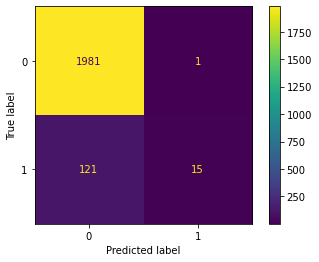

In [422]:
m.plot_confusion_matrix(best_mod, test_X, test_y)

In [423]:
score = m.balanced_accuracy_score(test_y, pred_y)
print(score)
score_list.append(score)

0.5548947883896242


## Split the data for civil liberties

In [424]:
# split 
y = civil_liberties.backsliding
X = civil_liberties.drop(columns="backsliding")
train_X, test_X, train_y, test_y = train_test_split(X,y,test_size = .25,random_state=202011)

## Explore the training data

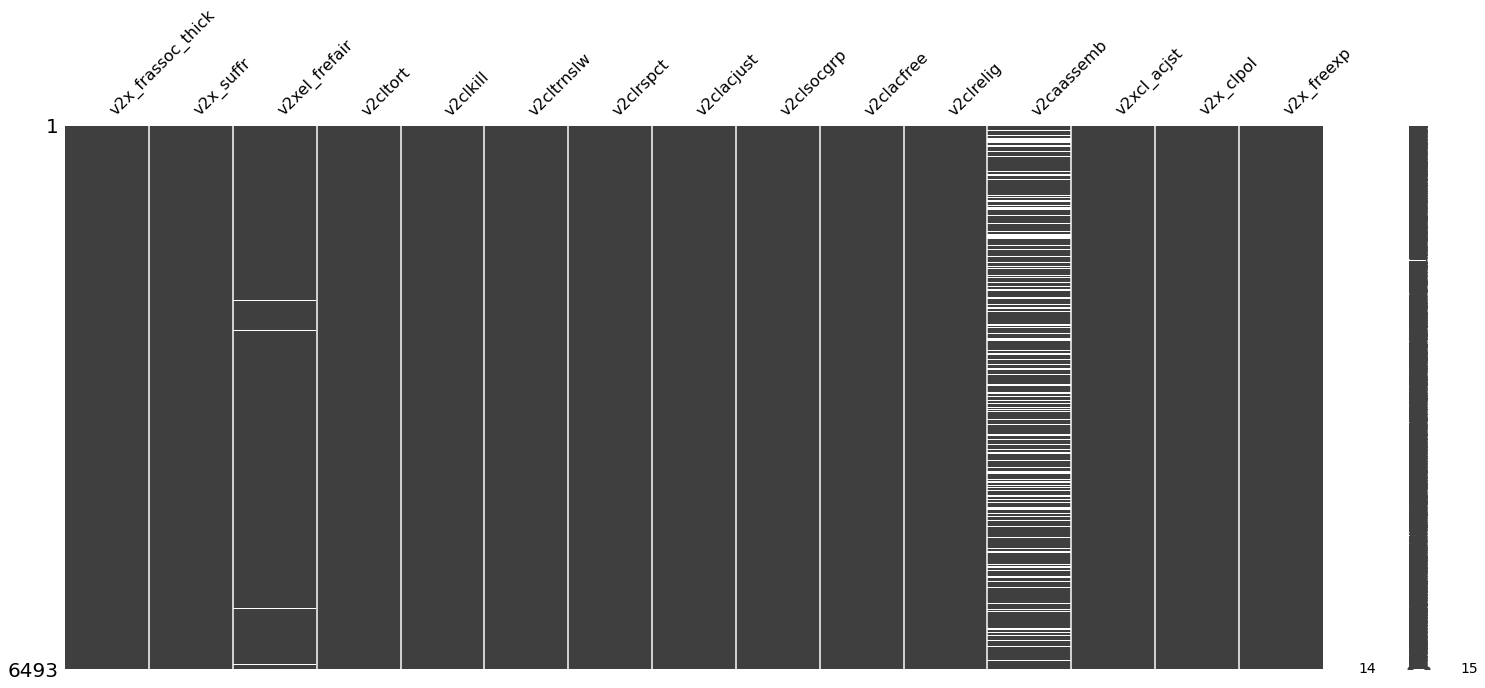

In [425]:
# missingness
miss.matrix(train_X)

In [426]:
train_X.isna().sum()

v2x_frassoc_thick       0
v2x_suffr               0
v2xel_frefair          13
v2cltort                0
v2clkill                0
v2cltrnslw              0
v2clrspct               0
v2clacjust              0
v2clsocgrp              0
v2clacfree              0
v2clrelig               0
v2caassemb           1580
v2xcl_acjst             0
v2x_clpol               0
v2x_freexp              0
dtype: int64

In [427]:
train_X.dropna(inplace=True)

In [428]:
train_X.describe()

,v2x_frassoc_thick,v2x_suffr,v2xel_frefair,v2cltort,v2clkill,v2cltrnslw,v2clrspct,v2clacjust,v2clsocgrp,v2clacfree,v2clrelig,v2caassemb,v2xcl_acjst,v2x_clpol,v2x_freexp
count,4900.000000,4900.000000,4900.000000,4900.000000,4900.000000,4900.000000,4900.000000,4900.000000,4900.000000,4900.000000,4900.000000,4900.000000,4900.000000,4900.000000,4900.00000
mean,0.533093,0.958110,0.462235,0.268452,0.503158,0.367212,0.081856,0.812205,0.526873,0.436238,0.551949,0.373903,0.564319,0.564871,0.55522
std,0.337774,0.178757,0.342035,1.620660,1.629914,1.464511,1.483677,1.201145,1.314202,1.659785,1.509791,1.614148,0.289954,0.332978,0.32387
min,0.021000,0.000000,0.000000,-3.268000,-3.587000,-3.625000,-3.368000,-2.535000,-3.033000,-3.327000,-3.965000,-3.123000,0.005000,0.010000,0.01100
25%,0.149750,1.000000,0.155000,-1.003750,-0.716000,-0.746000,-0.982000,0.150250,-0.534000,-0.809000,-0.536000,-0.971250,0.295750,0.221000,0.23800
50%,0.627000,1.000000,0.428000,0.229000,0.591000,0.196000,-0.207000,0.943000,0.706000,0.624000,1.075000,0.478000,0.590500,0.627000,0.61000
75%,0.865000,1.000000,0.816250,1.621250,1.951000,1.462000,0.996000,1.629000,1.536000,1.801000,1.739000,1.769000,0.819250,0.893000,0.87125
max,0.954000,1.000000,0.985000,3.321000,3.071000,3.512000,3.607000,3.209000,3.079000,3.287000,2.823000,3.061000,0.991000,0.983000,0.98800


In [429]:
a = train_X.melt()

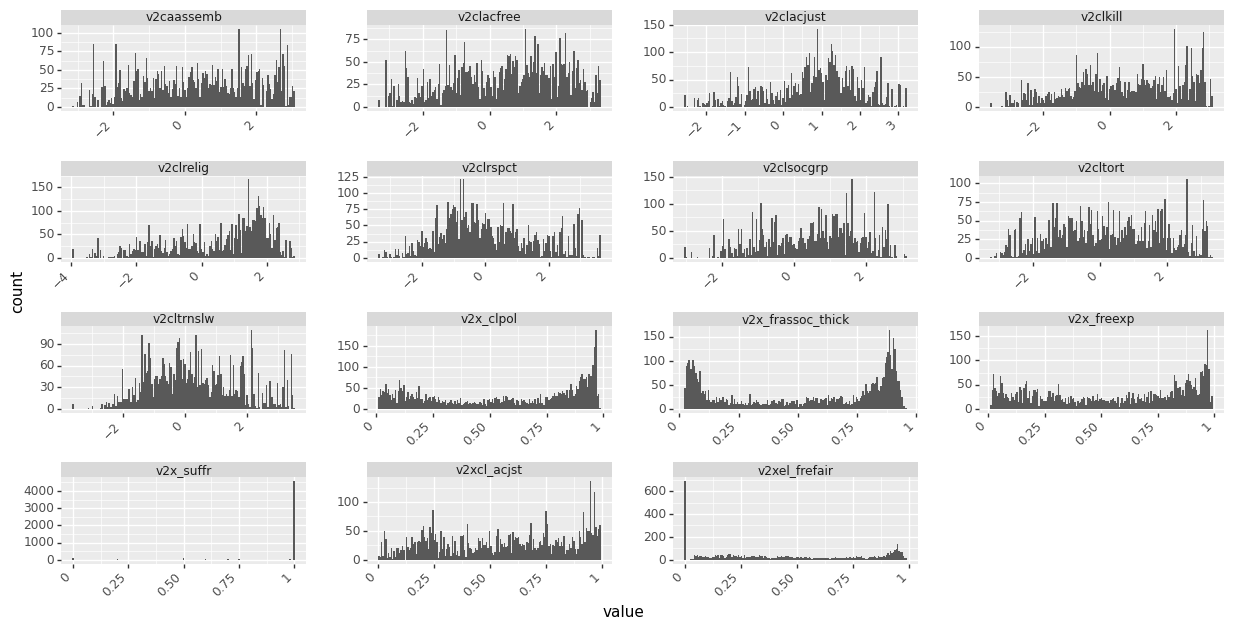

<ggplot: (305417033)>

In [430]:
(
    ggplot(a,aes(x="value")) +
    geom_histogram() +
    facet_wrap("variable" , scales='free') +
    theme(figure_size=(15,7),
          subplots_adjust={'wspace':0.25,
                           'hspace':0.75},
         axis_text_x=element_text(rotation=45, hjust=1))
)

## Make edits to full data

In [431]:
civil_liberties.dropna(inplace=True)

## Split the data again

In [432]:
# split 
y = civil_liberties.backsliding
X = civil_liberties.drop(columns="backsliding")
train_X, test_X, train_y, test_y = train_test_split(X,y,test_size = .25,random_state=202011)

## Model

In [433]:
# Build the modeling pipeline
pipe = Pipeline(steps=[('pre_process', preprocess),('model',None)])

search_space = [
    
    # NaiveBayes
    {'model': [NB()]},
    
    # KNN with K tuning param
    {'model' : [KNN()],
     'model__n_neighbors':[5,10,25,50]},
    
    # Decision Tree with the Max Depth Param
    {'model': [DT()],
     'model__max_depth':[2,3,4]},
    
    # Random forest with the N Estimators, max depth, and max features tuning param
    {'model' : [RF()],
    'model__max_depth':[6,7,8],
    'model__n_estimators':[500,1000,1500],
    'model__max_features': [5,10,15]},
    
]

# Grid Search to find the best parameters. The metric used for evaluation is ROC AUC
search = GridSearchCV(pipe, search_space, 
                      cv = fold_generator,
                      scoring='roc_auc',
                      n_jobs=4)

# fit the data with the model
search.fit(train_X,train_y)

GridSearchCV(cv=KFold(n_splits=5, random_state=1234, shuffle=True),
             estimator=Pipeline(steps=[('pre_process', MinMaxScaler()),
                                       ('model', None)]),
             n_jobs=4,
             param_grid=[{'model': [GaussianNB()]},
                         {'model': [KNeighborsClassifier()],
                          'model__n_neighbors': [5, 10, 25, 50]},
                         {'model': [DecisionTreeClassifier()],
                          'model__max_depth': [2, 3, 4]},
                         {'model': [RandomForestClassifier(max_depth=8,
                                                           max_features=5,
                                                           n_estimators=500)],
                          'model__max_depth': [6, 7, 8],
                          'model__max_features': [5, 10, 15],
                          'model__n_estimators': [500, 1000, 1500]}],
             scoring='roc_auc')

In [434]:
#this is our out of sample AUC score
search.best_score_ 

0.7287952906780593

In [435]:
# what model performs the best
search.best_params_

{'model': RandomForestClassifier(max_depth=8, max_features=5, n_estimators=500),
 'model__max_depth': 8,
 'model__max_features': 5,
 'model__n_estimators': 500}

In [436]:
# now what happens if we try on the test data
best_mod = search.best_estimator_

In [437]:
pred_y = best_mod.predict(test_X)
m.roc_auc_score(test_y, pred_y)

0.5046728971962616

In [438]:
confusion = m.confusion_matrix(test_y, pred_y)
print(confusion)
confusion_list.append(confusion)

[[1535    0]
 [ 106    1]]


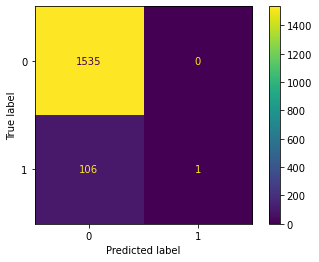

In [439]:
m.plot_confusion_matrix(best_mod, test_X, test_y)

In [440]:
score = m.balanced_accuracy_score(test_y, pred_y)
print(score)
score_list.append(score)

0.5046728971962616


## Split the data for civil society

In [441]:
# split 
y = civil_society.backsliding
X = civil_society.drop(columns="backsliding")
train_X, test_X, train_y, test_y = train_test_split(X,y,test_size = .25,random_state=202011)

## Explore the training data

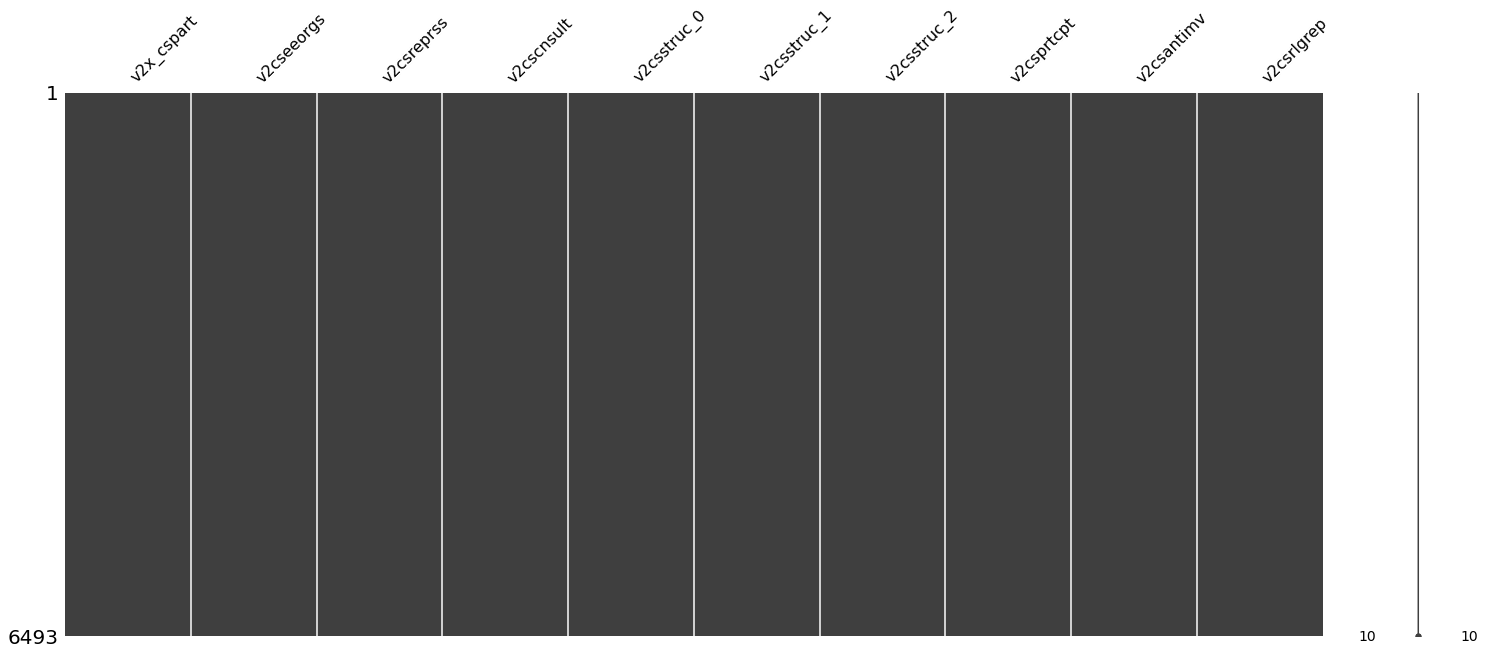

In [442]:
# missingness
miss.matrix(train_X)

In [443]:
train_X.isna().sum()

v2x_cspart     0
v2cseeorgs     0
v2csreprss     0
v2cscnsult     0
v2csstruc_0    0
v2csstruc_1    0
v2csstruc_2    0
v2csprtcpt     0
v2csantimv     0
v2csrlgrep     0
dtype: int64

In [444]:
train_X.dropna(inplace=True)

In [445]:
train_X.describe()

,v2x_cspart,v2cseeorgs,v2csreprss,v2cscnsult,v2csstruc_0,v2csstruc_1,v2csstruc_2,v2csprtcpt,v2csantimv,v2csrlgrep
count,6493.000000,6493.000000,6493.000000,6493.000000,6493.000000,6493.000000,6493.000000,6493.000000,6493.000000,6493.000000
mean,0.547167,0.402491,0.374882,0.255299,0.186919,0.297367,0.437720,0.247654,-0.475046,0.488160
std,0.287039,1.565959,1.582707,1.448381,0.282165,0.236145,0.271997,1.479853,1.273871,1.447499
min,0.016000,-3.218000,-3.599000,-2.444000,0.000000,0.000000,0.000000,-3.209000,-2.989000,-4.152000
25%,0.291000,-0.870000,-0.858000,-0.908000,0.000000,0.133000,0.200000,-0.680000,-1.378000,-0.517000
50%,0.573000,0.524000,0.337000,0.225000,0.000000,0.250000,0.412000,0.515000,-0.635000,0.736000
75%,0.807000,1.786000,1.717000,1.294000,0.308000,0.429000,0.625000,1.351000,0.511000,1.825000
max,0.986000,3.607000,3.210000,3.470000,1.000000,1.000000,1.000000,2.920000,4.016000,2.617000


In [446]:
a = train_X.melt()

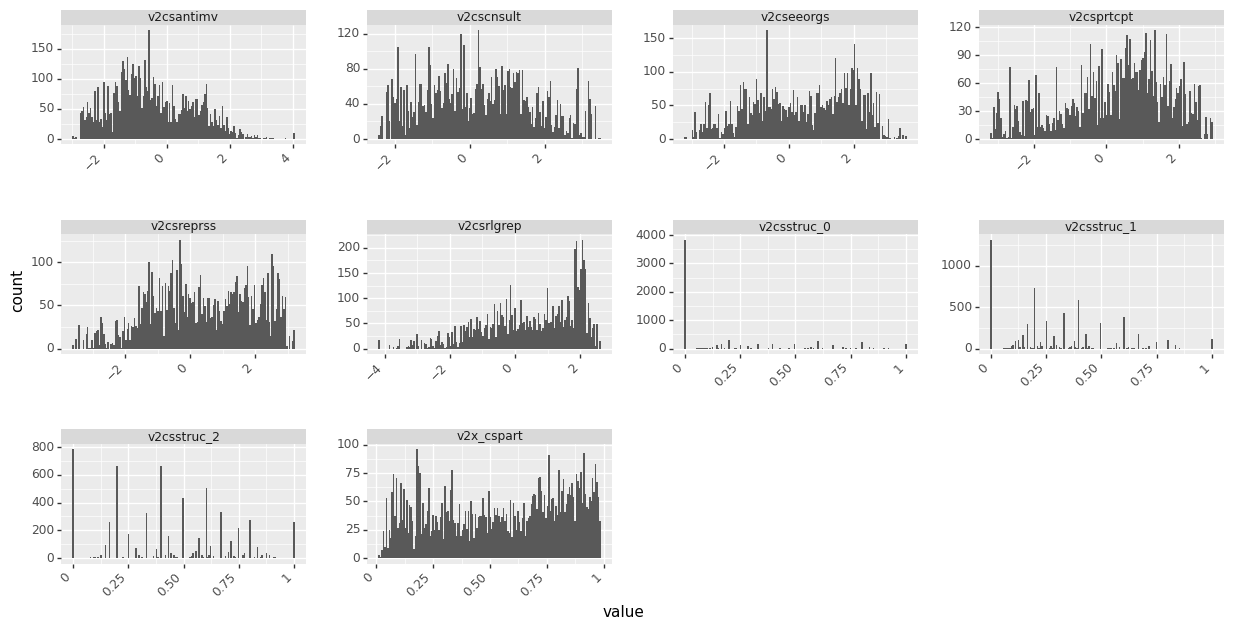

<ggplot: (346872914)>

In [447]:
(
    ggplot(a,aes(x="value")) +
    geom_histogram() +
    facet_wrap("variable" , scales='free') +
    theme(figure_size=(15,7),
          subplots_adjust={'wspace':0.25,
                           'hspace':0.75},
         axis_text_x=element_text(rotation=45, hjust=1))
)

## Make edits to full data

In [448]:
civil_society.dropna(inplace = True)

## Split again

In [449]:
# split 
y = civil_society.backsliding
X = civil_society.drop(columns="backsliding")
train_X, test_X, train_y, test_y = train_test_split(X,y,test_size = .25,random_state=202011)

## Model

In [450]:
# Build the modeling pipeline
pipe = Pipeline(steps=[('pre_process', preprocess),('model',None)])

search_space = [
    
    # NaiveBayes
    {'model': [NB()]},
    
    # KNN with K tuning param
    {'model' : [KNN()],
     'model__n_neighbors':[5,10,25,50]},
    
    # Decision Tree with the Max Depth Param
    {'model': [DT()],
     'model__max_depth':[2,3,4]},
    
    # Random forest with the N Estimators, max depth, and max features tuning param
    {'model' : [RF()],
    'model__max_depth':[6,7,8],
    'model__n_estimators':[500,1000,1500],
    'model__max_features': [5,10,15]},
    
]

# Grid Search to find the best parameters. The metric used for evaluation is ROC AUC
search = GridSearchCV(pipe, search_space, 
                      cv = fold_generator,
                      scoring='roc_auc',
                      n_jobs=4)

# fit the data with the model
search.fit(train_X,train_y)

GridSearchCV(cv=KFold(n_splits=5, random_state=1234, shuffle=True),
             estimator=Pipeline(steps=[('pre_process', MinMaxScaler()),
                                       ('model', None)]),
             n_jobs=4,
             param_grid=[{'model': [GaussianNB()]},
                         {'model': [KNeighborsClassifier()],
                          'model__n_neighbors': [5, 10, 25, 50]},
                         {'model': [DecisionTreeClassifier()],
                          'model__max_depth': [2, 3, 4]},
                         {'model': [RandomForestClassifier(max_depth=8,
                                                           max_features=5,
                                                           n_estimators=500)],
                          'model__max_depth': [6, 7, 8],
                          'model__max_features': [5, 10, 15],
                          'model__n_estimators': [500, 1000, 1500]}],
             scoring='roc_auc')

In [451]:
#this is our out of sample AUC score
search.best_score_ 

0.7431480206875574

In [452]:
# what model performs the best
search.best_params_

{'model': RandomForestClassifier(max_depth=8, max_features=5, n_estimators=500),
 'model__max_depth': 8,
 'model__max_features': 5,
 'model__n_estimators': 500}

In [453]:
# now what happens if we try on the test data
best_mod = search.best_estimator_

In [454]:
pred_y = best_mod.predict(test_X)
m.roc_auc_score(test_y, pred_y)

0.5534664922822857

In [455]:
confusion = m.confusion_matrix(test_y, pred_y)
print(confusion)
confusion_list.append(confusion)

[[1996    3]
 [ 148   18]]


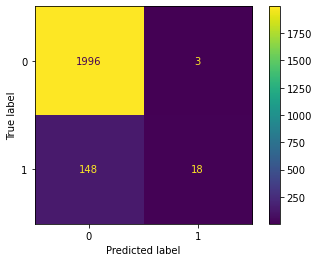

In [456]:
m.plot_confusion_matrix(best_mod, test_X, test_y)

In [457]:
score = m.balanced_accuracy_score(test_y, pred_y)
print(score)
score_list.append(score)

0.5534664922822857


## Split the data for media

In [458]:
# split 
y = media.backsliding
X = media.drop(columns="backsliding")
train_X, test_X, train_y, test_y = train_test_split(X,y,test_size = .25,random_state=202011)

## Explore Training Data

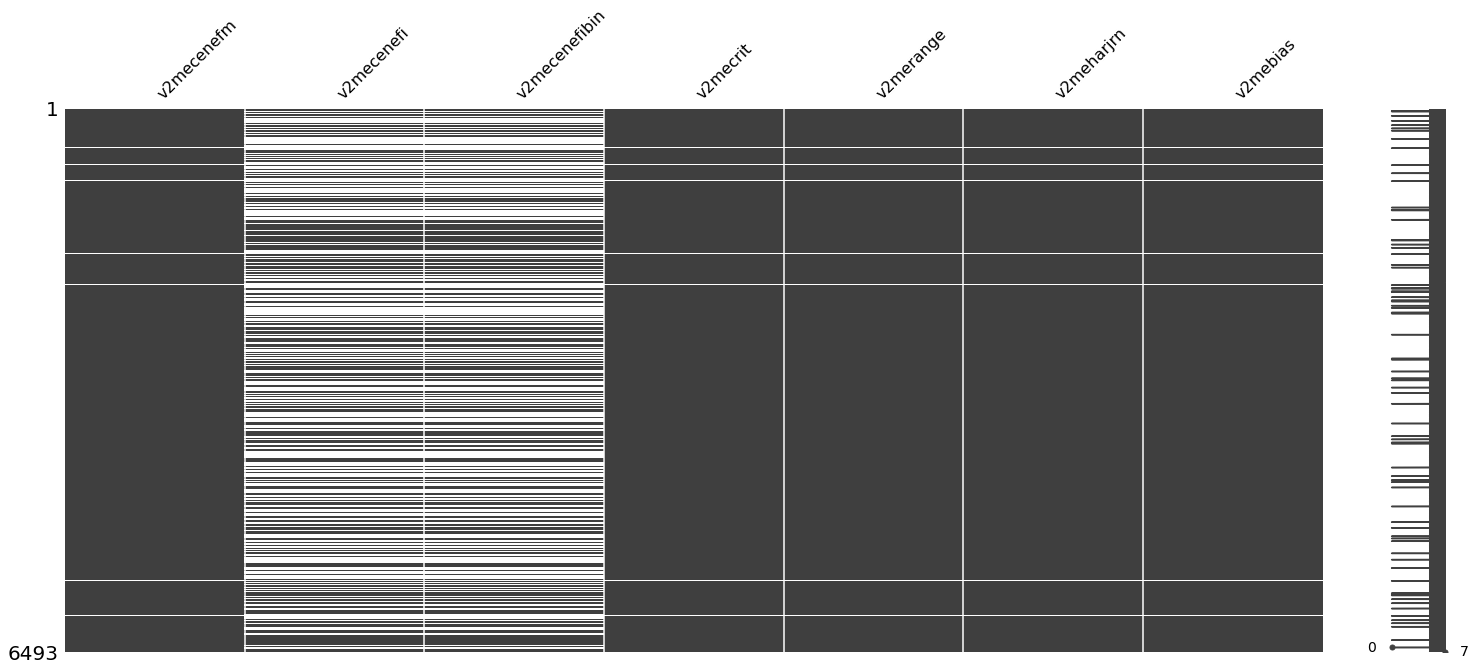

In [459]:
# missingness
miss.matrix(train_X)

In [460]:
train_X.isna().sum()

v2mecenefm         79
v2mecenefi       3584
v2mecenefibin    3584
v2mecrit           79
v2merange          79
v2meharjrn         79
v2mebias           79
dtype: int64

In [461]:
train_X.dropna(inplace=True)

In [462]:
train_X.describe()

,v2mecenefm,v2mecenefi,v2mecenefibin,v2mecrit,v2merange,v2meharjrn,v2mebias
count,2909.000000,2909.000000,2909.000000,2909.000000,2909.000000,2909.000000,2909.000000
mean,0.689193,0.302530,0.069258,0.902405,0.860216,0.679660,0.832399
std,1.463233,1.362792,1.002249,1.375801,1.343735,1.336267,1.351526
min,-3.025000,-4.205000,-5.054000,-3.327000,-3.201000,-3.181000,-3.283000
25%,-0.316000,-0.541000,0.419000,0.158000,0.157000,-0.189000,0.236000
50%,0.766000,0.755000,0.452000,1.123000,1.278000,0.696000,1.110000
75%,1.790000,1.501000,0.473000,2.060000,1.831000,1.660000,1.828000
max,3.327000,1.846000,0.549000,3.036000,2.714000,3.917000,3.040000


In [463]:
a = train_X.melt()

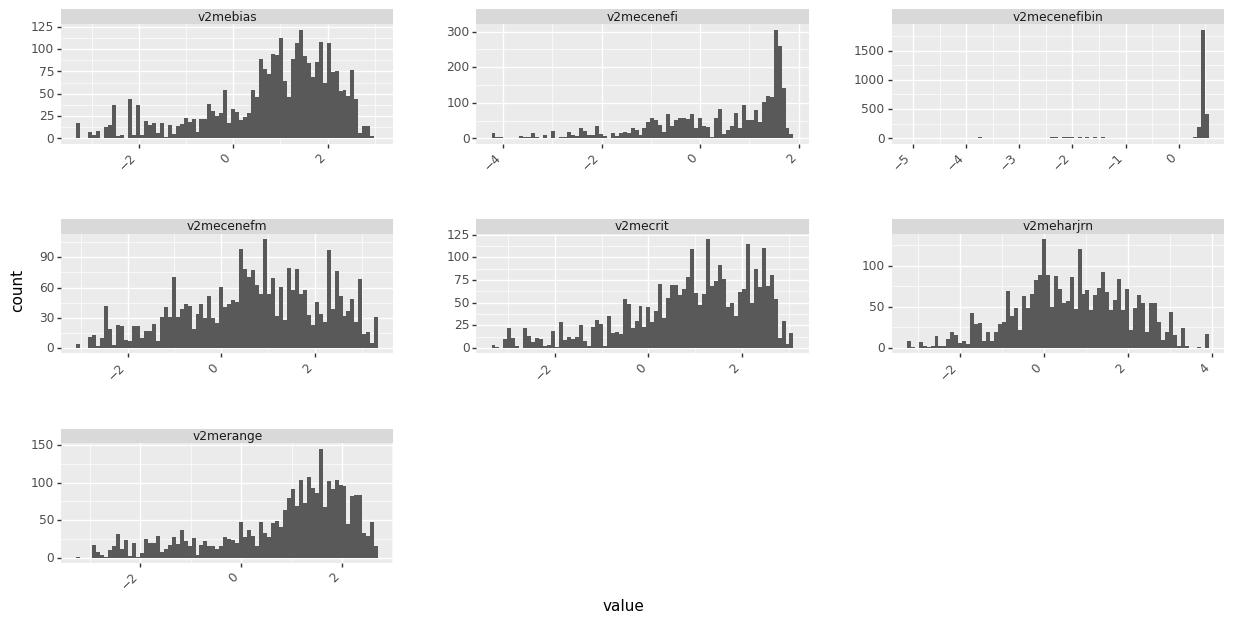

<ggplot: (340552569)>

In [464]:
(
    ggplot(a,aes(x="value")) +
    geom_histogram() +
    facet_wrap("variable" , scales='free') +
    theme(figure_size=(15,7),
          subplots_adjust={'wspace':0.25,
                           'hspace':0.75},
         axis_text_x=element_text(rotation=45, hjust=1))
)

## Edit Full Data

In [465]:
media.dropna(inplace=True)

## Split again

In [466]:
# split 
y = media.backsliding
X = media.drop(columns="backsliding")
train_X, test_X, train_y, test_y = train_test_split(X,y,test_size = .25,random_state=202011)

## Model

In [467]:
# Build the modeling pipeline
pipe = Pipeline(steps=[('pre_process', preprocess),('model',None)])

search_space = [
    
    # NaiveBayes
    {'model': [NB()]},
    
    # KNN with K tuning param
    {'model' : [KNN()],
     'model__n_neighbors':[5,10,25,50]},
    
    # Decision Tree with the Max Depth Param
    {'model': [DT()],
     'model__max_depth':[2,3,4]},
    
    # Random forest with the N Estimators, max depth, and max features tuning param
    {'model' : [RF()],
    'model__max_depth':[6,7,8],
    'model__n_estimators':[500,1000,1500],
    'model__max_features': [5,10,15]},
    
]

# Grid Search to find the best parameters. The metric used for evaluation is ROC AUC
search = GridSearchCV(pipe, search_space, 
                      cv = fold_generator,
                      scoring='roc_auc',
                      n_jobs=4)

# fit the data with the model
search.fit(train_X,train_y)

GridSearchCV(cv=KFold(n_splits=5, random_state=1234, shuffle=True),
             estimator=Pipeline(steps=[('pre_process', MinMaxScaler()),
                                       ('model', None)]),
             n_jobs=4,
             param_grid=[{'model': [GaussianNB()]},
                         {'model': [KNeighborsClassifier()],
                          'model__n_neighbors': [5, 10, 25, 50]},
                         {'model': [DecisionTreeClassifier()],
                          'model__max_depth': [2, 3, 4]},
                         {'model': [RandomForestClassifier(max_depth=8,
                                                           max_features=5,
                                                           n_estimators=500)],
                          'model__max_depth': [6, 7, 8],
                          'model__max_features': [5, 10, 15],
                          'model__n_estimators': [500, 1000, 1500]}],
             scoring='roc_auc')

In [468]:
#this is our out of sample AUC score
search.best_score_ 

0.7729211136265196

In [469]:
# what model performs the best
search.best_params_

{'model': RandomForestClassifier(max_depth=8, max_features=5, n_estimators=500),
 'model__max_depth': 8,
 'model__max_features': 5,
 'model__n_estimators': 500}

In [470]:
# now what happens if we try on the test data
best_mod = search.best_estimator_

In [471]:
pred_y = best_mod.predict(test_X)
m.roc_auc_score(test_y, pred_y)

0.5952380952380952

In [472]:
confusion = m.confusion_matrix(test_y, pred_y)
print(confusion)
confusion_list.append(confusion)

[[924   0]
 [ 34   8]]


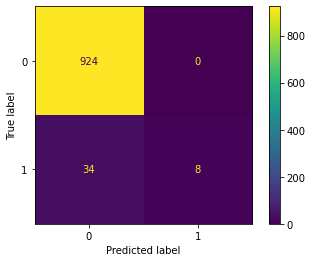

In [473]:
m.plot_confusion_matrix(best_mod, test_X, test_y)

In [474]:
score = m.balanced_accuracy_score(test_y, pred_y)
print(score)
score_list.append(score)

0.5952380952380952


## Split Econ Data

In [475]:
# split 
y = econ.backsliding
X = econ.drop(columns="backsliding")
train_X, test_X, train_y, test_y = train_test_split(X,y,test_size = .25,random_state=202011)

## Explore Training Data


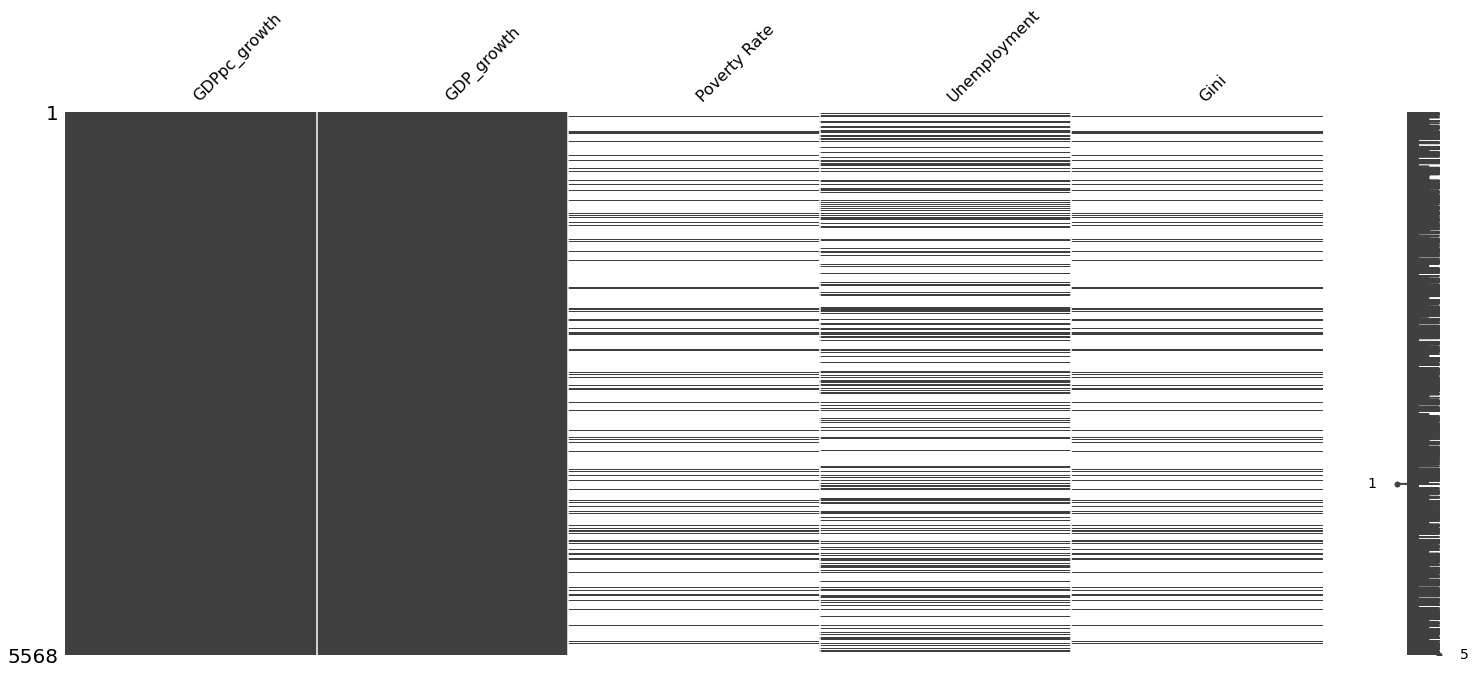

In [476]:
# missingness
miss.matrix(train_X)

In [477]:
train_X.isna().sum()

GDPpc_growth       1
GDP_growth         1
Poverty Rate    4643
Unemployment    3807
Gini            4647
dtype: int64

In [478]:
train_X.dropna(inplace=True)

In [479]:
train_X.describe()

,GDPpc_growth,GDP_growth,Poverty Rate,Unemployment,Gini
count,653.000000,653.000000,653.000000,653.000000,653.000000
mean,2.263047,3.151742,5.923430,0.082387,37.988821
std,4.134799,4.254603,11.348787,0.050106,9.255891
min,-16.600000,-17.000000,0.000000,0.004890,22.900000
25%,0.459000,1.230000,0.200000,0.047200,31.100000
50%,2.510000,3.560000,1.000000,0.072700,35.500000
75%,4.460000,5.410000,6.600000,0.102000,43.900000
max,16.200000,18.000000,77.400000,0.322000,64.800000


In [480]:
a = train_X.melt()

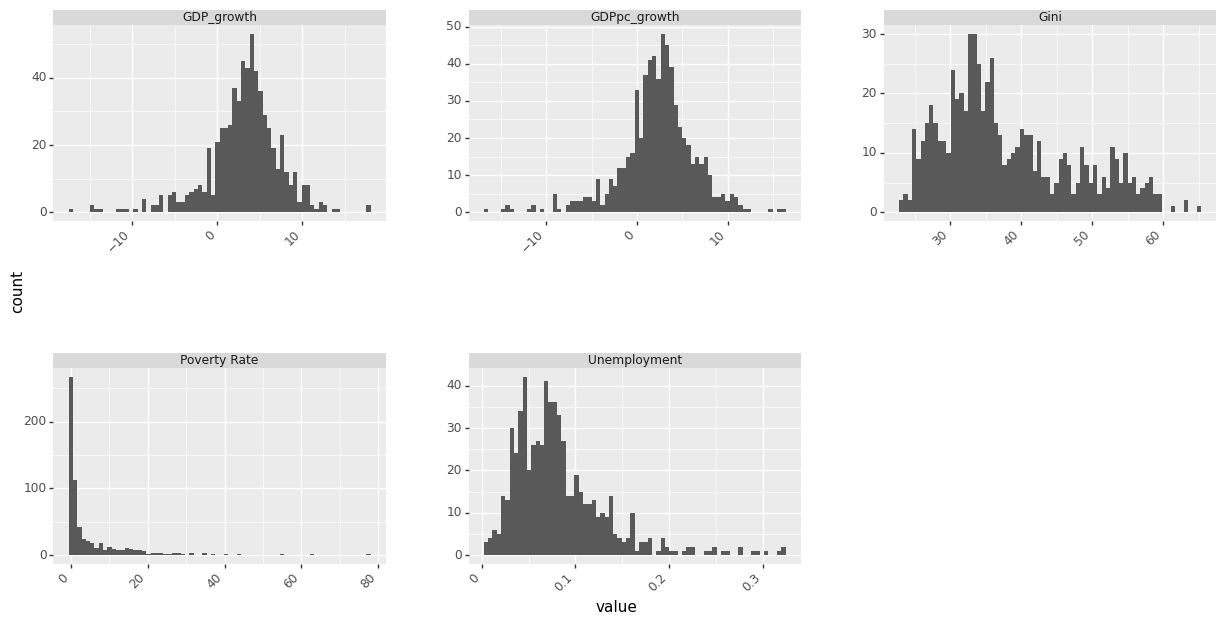

<ggplot: (311437008)>

In [481]:
(
    ggplot(a,aes(x="value")) +
    geom_histogram() +
    facet_wrap("variable" , scales='free') +
    theme(figure_size=(15,7),
          subplots_adjust={'wspace':0.25,
                           'hspace':0.75},
         axis_text_x=element_text(rotation=45, hjust=1))
)

## Edit Full Data

In [482]:
econ.dropna(inplace=True)

## Split again

In [483]:
# split 
y = econ.backsliding
X = econ.drop(columns="backsliding")
train_X, test_X, train_y, test_y = train_test_split(X,y,test_size = .25,random_state=202011)

## Model

In [484]:
# Build the modeling pipeline
pipe = Pipeline(steps=[('pre_process', preprocess),('model',None)])

search_space = [
    
    # NaiveBayes
    {'model': [NB()]},
    
    # KNN with K tuning param
    {'model' : [KNN()],
     'model__n_neighbors':[5,10,25,50]},
    
    # Decision Tree with the Max Depth Param
    {'model': [DT()],
     'model__max_depth':[2,3,4]},
    
    # Random forest with the N Estimators, max depth, and max features tuning param
    {'model' : [RF()],
    'model__max_depth':[6,7,8],
    'model__n_estimators':[500,1000,1500],
    'model__max_features': [5,10,15]},
    
]

# Grid Search to find the best parameters. The metric used for evaluation is ROC AUC
search = GridSearchCV(pipe, search_space, 
                      cv = fold_generator,
                      scoring='roc_auc',
                      n_jobs=4)

# fit the data with the model
search.fit(train_X,train_y)

GridSearchCV(cv=KFold(n_splits=5, random_state=1234, shuffle=True),
             estimator=Pipeline(steps=[('pre_process', MinMaxScaler()),
                                       ('model', None)]),
             n_jobs=4,
             param_grid=[{'model': [GaussianNB()]},
                         {'model': [KNeighborsClassifier()],
                          'model__n_neighbors': [5, 10, 25, 50]},
                         {'model': [DecisionTreeClassifier()],
                          'model__max_depth': [2, 3, 4]},
                         {'model': [RandomForestClassifier(max_depth=6,
                                                           max_features=5,
                                                           n_estimators=1500)],
                          'model__max_depth': [6, 7, 8],
                          'model__max_features': [5, 10, 15],
                          'model__n_estimators': [500, 1000, 1500]}],
             scoring='roc_auc')

In [485]:
#this is our out of sample AUC score
search.best_score_ 

0.5335354769892316

In [486]:
# what model performs the best
search.best_params_

{'model': RandomForestClassifier(max_depth=6, max_features=5, n_estimators=1500),
 'model__max_depth': 6,
 'model__max_features': 5,
 'model__n_estimators': 1500}

In [487]:
# now what happens if we try on the test data
best_mod = search.best_estimator_

In [488]:
pred_y = best_mod.predict(test_X)
m.roc_auc_score(test_y, pred_y)

0.4976303317535545

In [489]:
confusion = m.confusion_matrix(test_y, pred_y)
print(confusion)
confusion_list.append(confusion)

[[210   1]
 [  9   0]]


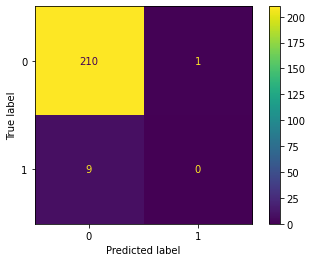

In [490]:
m.plot_confusion_matrix(best_mod, test_X, test_y)

In [491]:
score = m.balanced_accuracy_score(test_y, pred_y)
print(score)
score_list.append(score)

0.4976303317535545


## Plot list of scores

In [503]:
print(max(score_list))
min((score_list))

0.5952380952380952


0.4976303317535545

In [493]:
confusion_list

[array([[1346,    3],
        [  67,    5]]),
 array([[1981,    1],
        [ 121,   15]]),
 array([[1535,    0],
        [ 106,    1]]),
 array([[1996,    3],
        [ 148,   18]]),
 array([[924,   0],
        [ 34,   8]]),
 array([[210,   1],
        [  9,   0]])]